[View in Colaboratory](https://colab.research.google.com/github/avyukd/glaucoma_screener/blob/master/AEH_Screening_Project.ipynb)

In [12]:
!nvidia-smi


Sat Aug 18 05:28:44 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import matplotlib
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.misc
import random
import cv2
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import csv
from PIL import Image
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from scipy import ndimage
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf

In [14]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpqg2_42q1/pubring.gpg' created
gpg: /tmp/tmpqg2_42q1/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [19]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [33]:
#!unzip drive/FundusImagesv2.zip
#!unzip drive/FundusImagesv3.zip
!unzip -o drive/FundusImagesv4.zip

Archive:  drive/FundusImagesv4.zip
   creating: FundusImagesv4/glaucoma/
  inflating: FundusImagesv4/glaucoma/local_novessel1.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel10.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel11.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel12.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel13.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel14.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel15.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel16.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel17.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel18.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel19.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel2.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel20.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel21.jpg  
  inflating: FundusImagesv4/glaucoma/local_novessel22.jpg  
  inflating: FundusImagesv4/g

In [20]:
!ls drive

0dbce84c_600640.jpg
2017ShakespearePerformanceFestival-BlueDay.doc
2017ShakespearePerformanceFestival-BlueDay.doc.odt
2k17 MyPlayer Ratings Sheet v1.xlsx.ods
4ef8d50b_467995.jpg
AD_JV_WACFL4.docx
AD_JV_WACFL4.docx.odt
AEH_SCREENING_DATA.csv
AEH Screening Project.ipynb
akul_assignment.jpg
APA Table.pdf
avyukexercises.py
BPMN (19d063fc).html
BPMN.html
Canterbury Tales Essay.odt
captain vote count.ods
Captain vote count.ods
Civic Rep Aff.docx
Classroom
Colab Notebooks
Comp Sci Placement Test
ContextBuilder_Versions
CubeSat.pdf
Disease Detectives
downloadAttachments.zip
drishtiGS_027.png
DSC01280.JPG
EES Context Builder Problems Log.ods
eshaan_assignment.jpg
Event Spreadsheet TEAM BLUE_v3.xls
Event Spreadsheet TEAM BLUE_v3.xls.ods
Event Spreadsheet TEAM BLUE_v3.xls.ods (560f3c37)
Event Spreadsheet TEAM BLUE_v3.xls.ods (85de701c)
Event Spreadsheet TEAM GREEN_v3..xls
Event Spreadsheet TEAM GREEN_v3..xls.ods
FinalRobotCodeToPrint_ino.ino
First Lego League
FLL_Design_Quiz.odt
FoodGroupsAndCalo

In [21]:
import os
subdirs = os.listdir("FundusImagesv4")
print(len(os.listdir("FundusImagesv4/normal")))

98


In [0]:
raw = pd.read_csv("drive/AEH_SCREENING_DATA.csv")
diagnosis = raw.copy().drop(columns = ["AGE","IOP_RE","IOP_LE"])
diagnosis.head()

In [0]:
width = 96
height = 96

In [0]:
def create_model():
    model = Sequential()
    model.add(Flatten(input_shape=(width,height,3)))
    #model = Sequential()
    #model.add(Conv2D(10, (8, 8), input_shape=(width, height, 3), kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(32, (5, 5), kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('sigmoid'))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(16))
    model.add(Activation('sigmoid'))
    model.add(Dense(8))
    model.add(Activation('sigmoid'))
    model.add(Dense(4))
    model.add(Activation('sigmoid'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    opt = optimizers.SGD(lr=.1, momentum=0.5,nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [44]:
model = create_model()
train_generator = ImageDataGenerator().flow_from_directory(
        'FundusImagesv4/',
        target_size=(width, height),
        color_mode='rgb',
        classes=['glaucoma','normal'],
        batch_size=50)
model.fit_generator(
        train_generator,
        epochs=50)

model.save_weights("try_four.h5")

Found 168 images belonging to 2 classes.
Epoch 1/50
4/4 [==============================] - 0s 120ms/step - loss: 0.7056 - acc: 0.4344
Epoch 2/50
4/4 [==============================] - 0s 34ms/step - loss: 0.6881 - acc: 0.5940
Epoch 3/50
4/4 [==============================] - 0s 32ms/step - loss: 0.6816 - acc: 0.5798
Epoch 4/50
4/4 [==============================] - 0s 43ms/step - loss: 0.6814 - acc: 0.5869
Epoch 5/50
4/4 [==============================] - 0s 51ms/step - loss: 0.6762 - acc: 0.6082
Epoch 6/50
4/4 [==============================] - 0s 49ms/step - loss: 0.6890 - acc: 0.5656
Epoch 7/50
4/4 [==============================] - 0s 50ms/step - loss: 0.6797 - acc: 0.5869
Epoch 8/50
4/4 [==============================] - 0s 27ms/step - loss: 0.6763 - acc: 0.6011
Epoch 9/50
4/4 [==============================] - 0s 48ms/step - loss: 0.6754 - acc: 0.6224
Epoch 10/50
4/4 [==============================] - 0s 53ms/step - loss: 0.6788 - acc: 0.5869
Epoch 11/50
4/4 [====================

In [24]:
import cv2 
test = cv2.imread("drive/drishtiGS_027.png")
print(test)
test = cv2.resize(test,(width,height))
test = np.expand_dims(test, axis=0)

[[[ 18  89 183]
  [ 16  90 183]
  [ 17  91 184]
  ...
  [ 14  75 164]
  [ 18  79 168]
  [ 19  81 168]]

 [[ 18  89 183]
  [ 16  90 183]
  [ 17  91 184]
  ...
  [ 14  77 165]
  [ 16  79 167]
  [ 17  80 167]]

 [[ 21  92 186]
  [ 18  92 185]
  [ 18  92 185]
  ...
  [ 15  78 166]
  [ 15  78 166]
  [ 17  80 167]]

 ...

 [[ 12  38 117]
  [ 12  42 118]
  [ 11  41 117]
  ...
  [  8  39  99]
  [ 11  39 100]
  [ 13  41 102]]

 [[ 12  38 117]
  [ 12  42 118]
  [ 13  43 119]
  ...
  [ 11  42 102]
  [ 13  44 104]
  [ 11  39 100]]

 [[  9  35 114]
  [ 12  39 116]
  [ 13  43 119]
  ...
  [  7  41  98]
  [ 10  41  99]
  [  9  40  98]]]


In [47]:
model.predict(test)

array([[0.41929004, 0.58070993]], dtype=float32)

(50, 1)


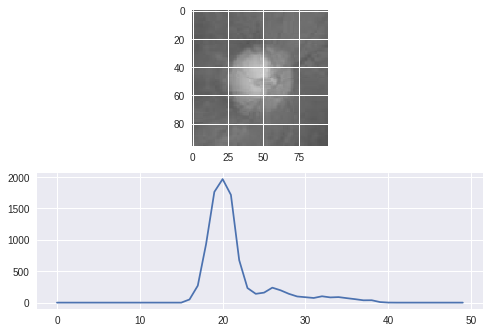

(50, 1)


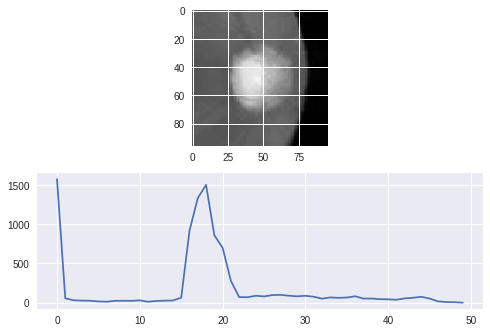

(50, 1)


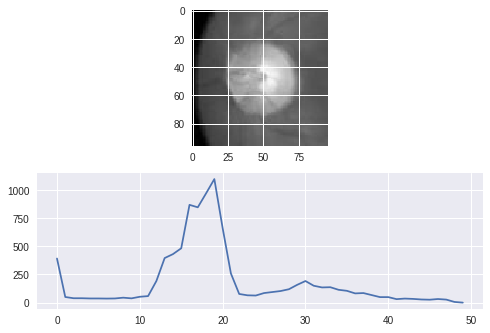

(50, 1)


(50, 1)


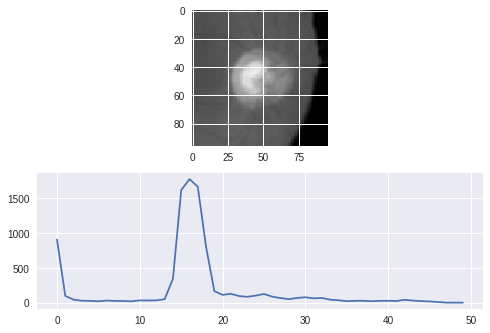

(50, 1)


(50, 1)


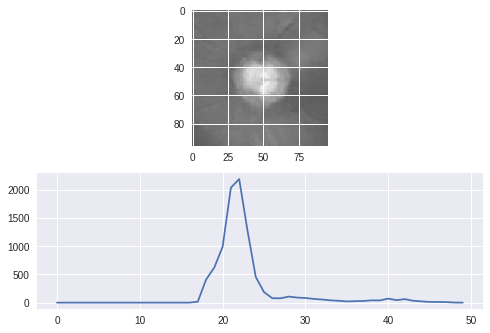

(50, 1)


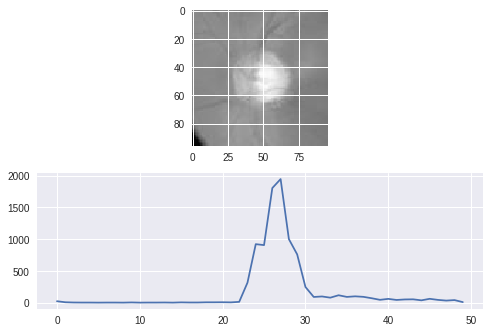

(50, 1)


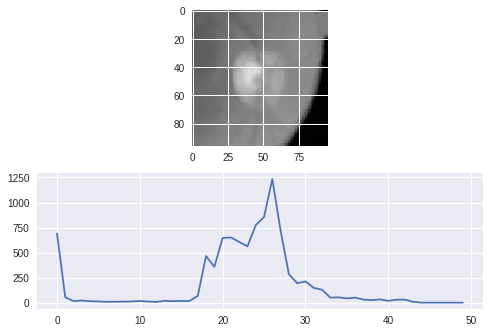

(50, 1)


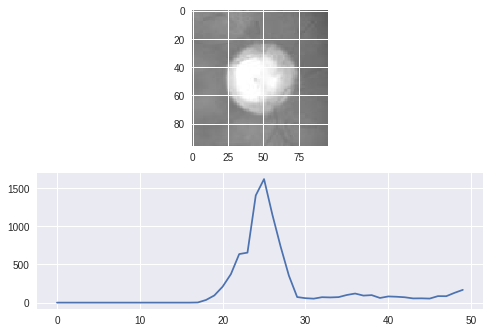

(50, 1)


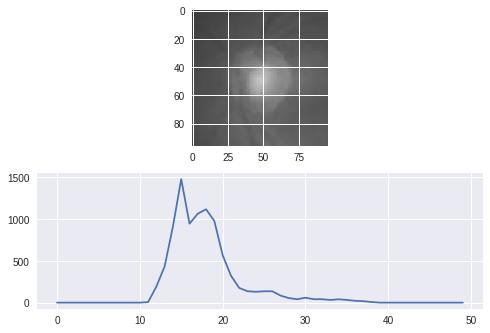

(50, 1)


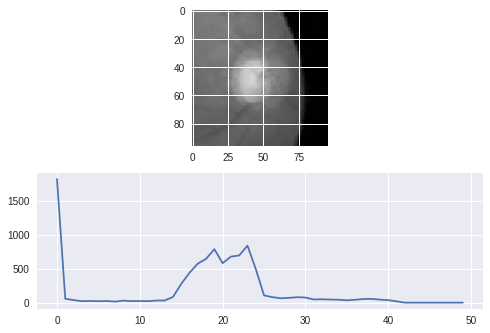

(50, 1)


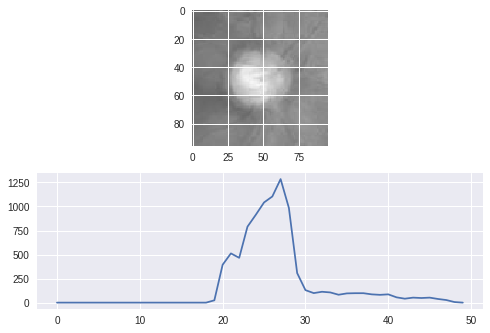

(50, 1)


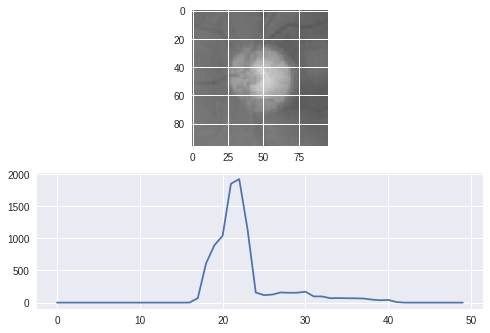

(50, 1)


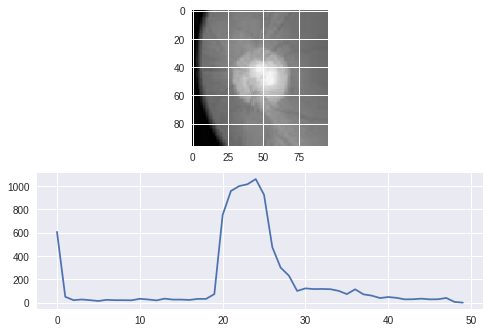

(50, 1)


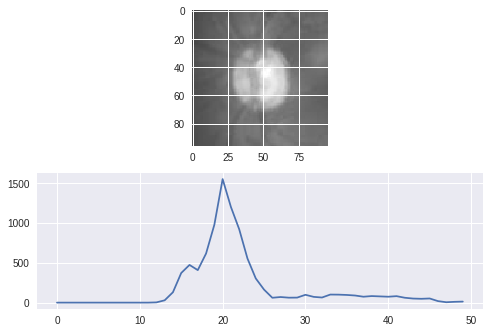

(50, 1)


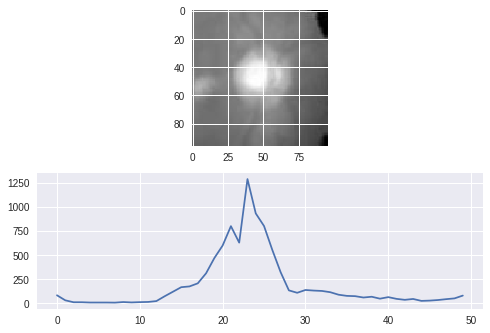

(50, 1)


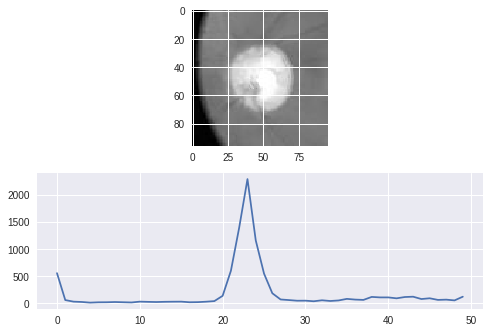

(50, 1)


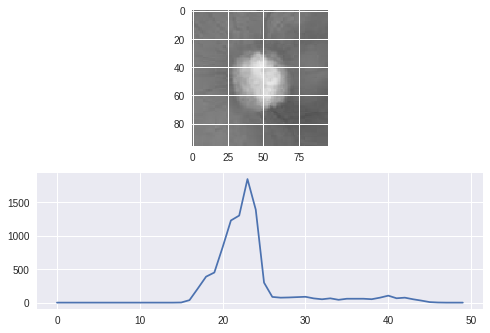

(50, 1)


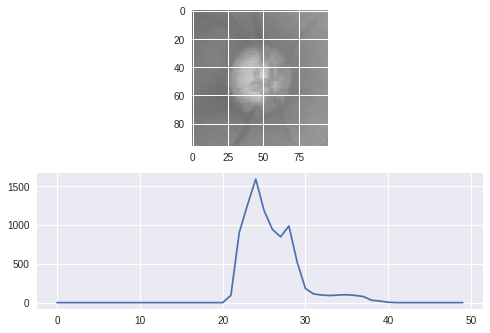

(50, 1)


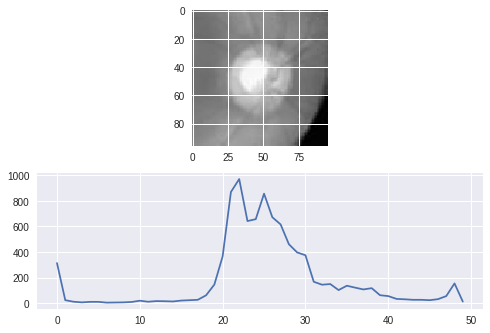

(50, 1)


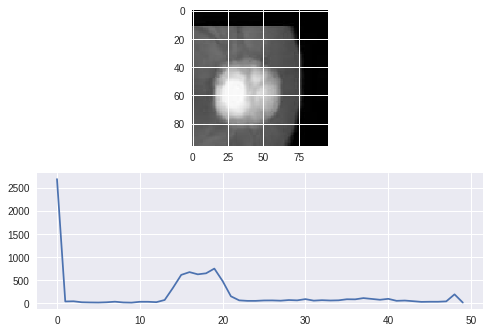

(50, 1)


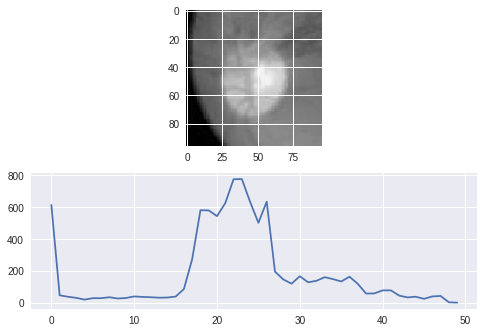

(50, 1)


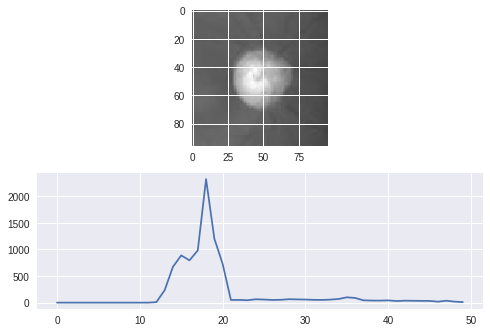

(50, 1)


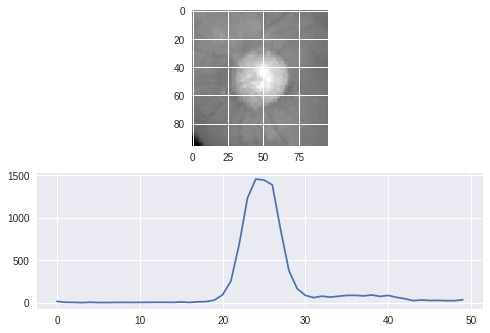

(50, 1)


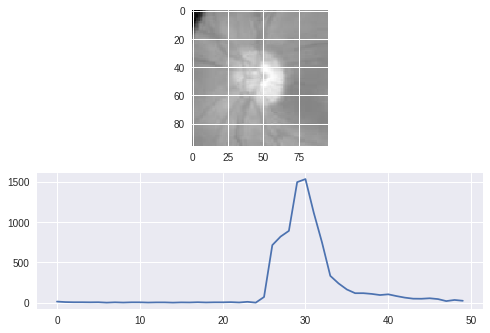

(50, 1)


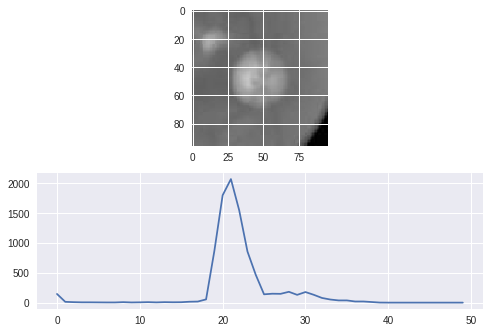

(50, 1)


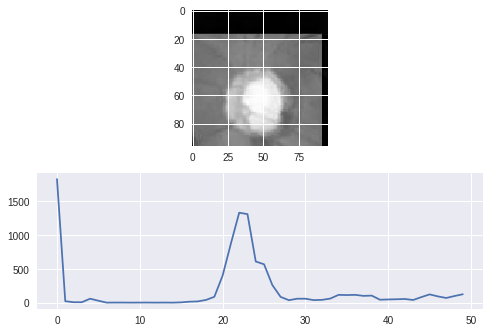

(50, 1)


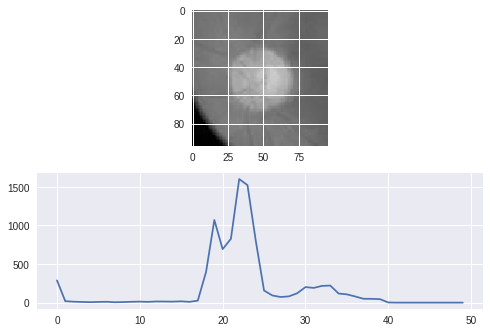

(50, 1)


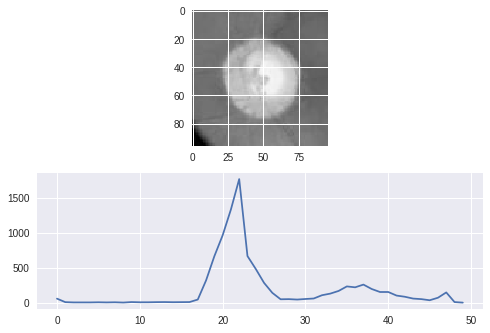

(50, 1)


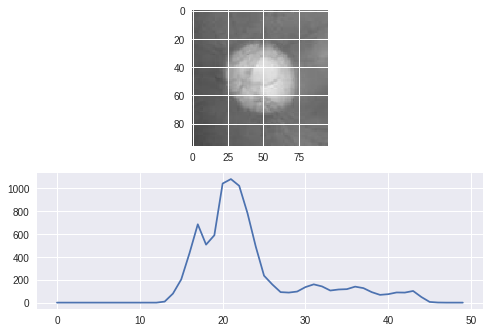

(50, 1)


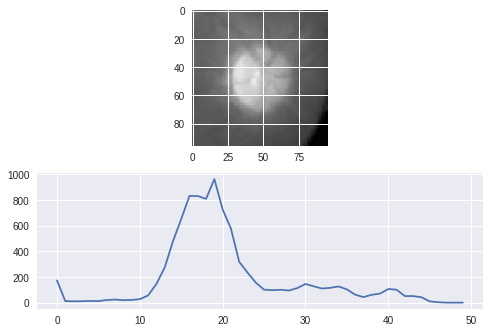

(50, 1)


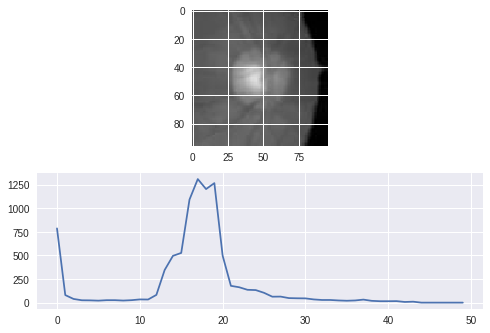

(50, 1)


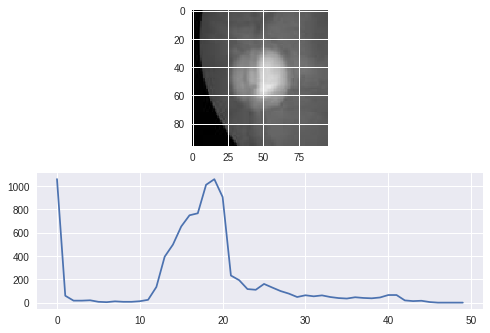

(50, 1)


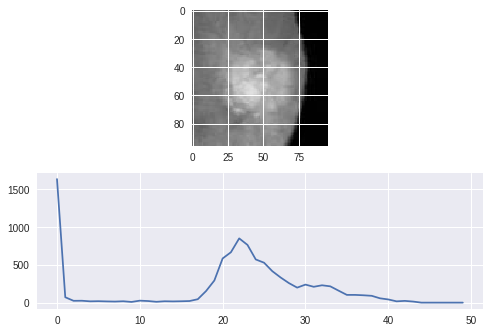

(50, 1)


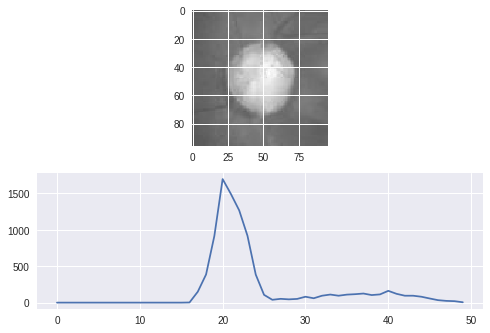

(50, 1)


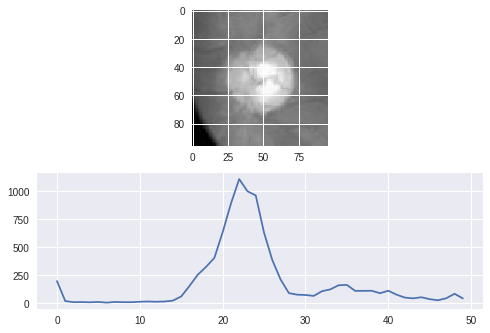

(50, 1)


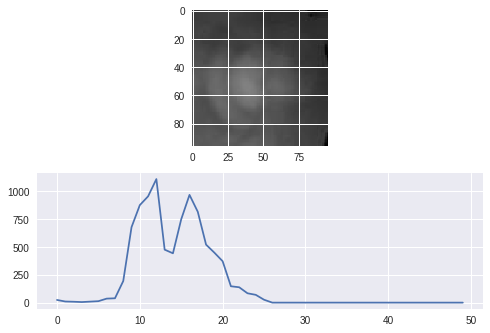

(50, 1)


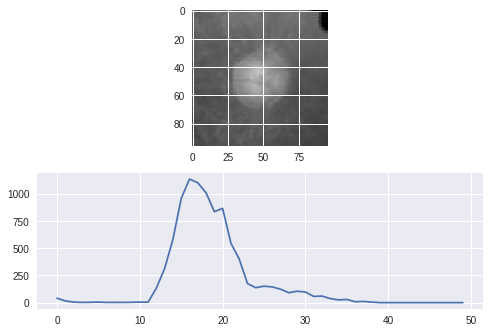

(50, 1)


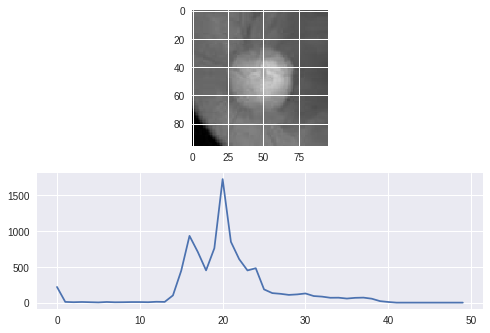

(50, 1)


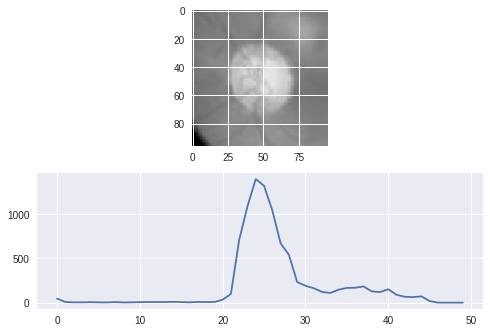

(50, 1)


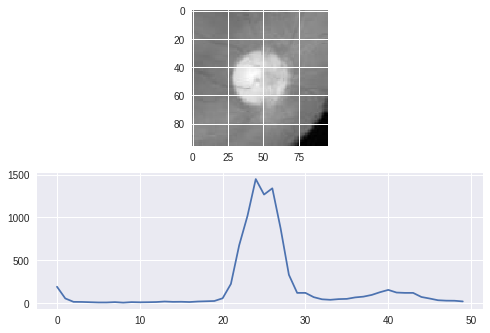

(50, 1)


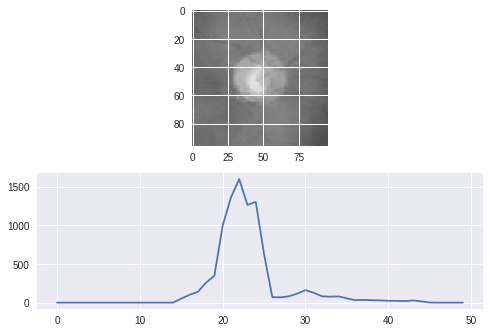

(50, 1)


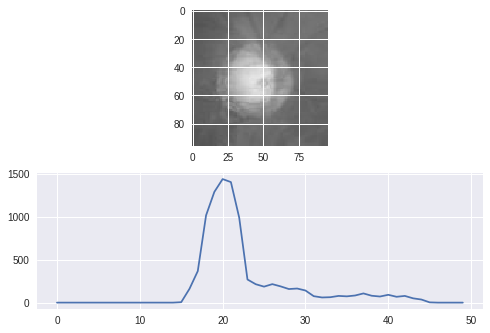

(50, 1)


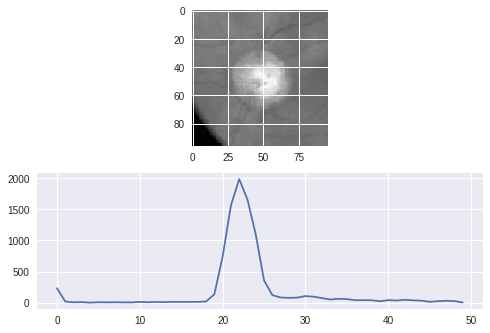

(50, 1)


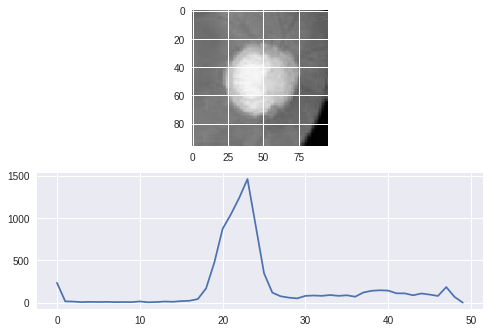

(50, 1)


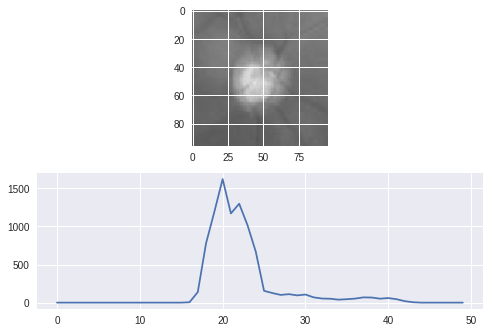

(50, 1)


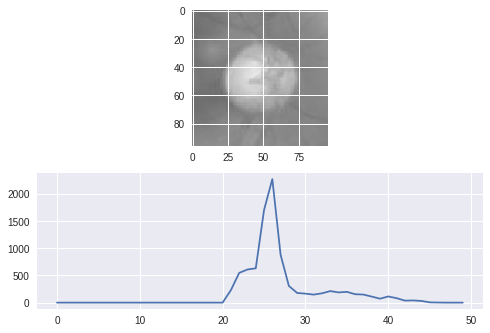

(50, 1)


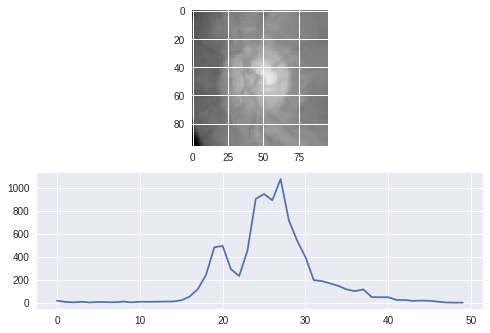

(50, 1)


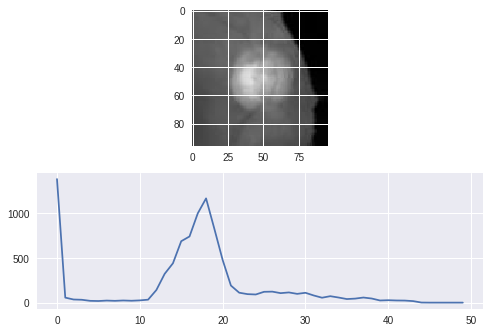

(50, 1)


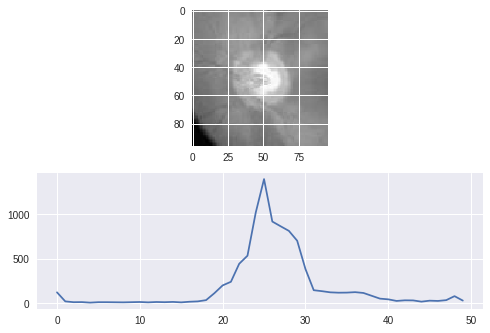

(50, 1)


(50, 1)


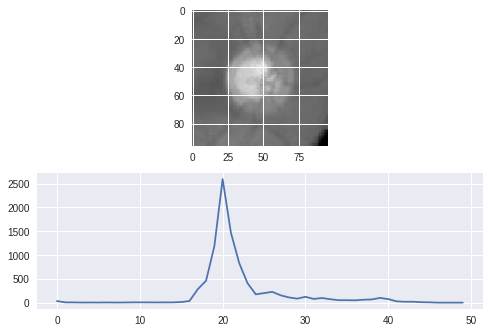

(50, 1)


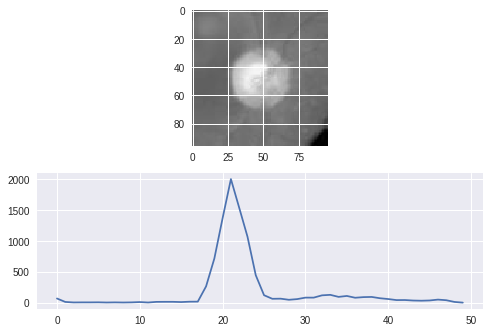

(50, 1)


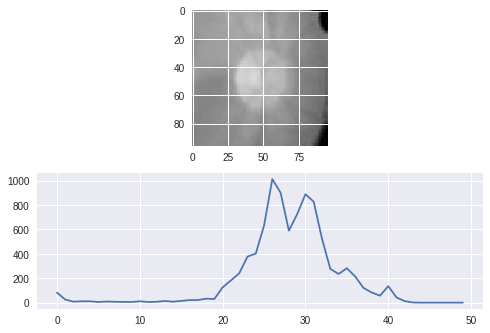

(50, 1)


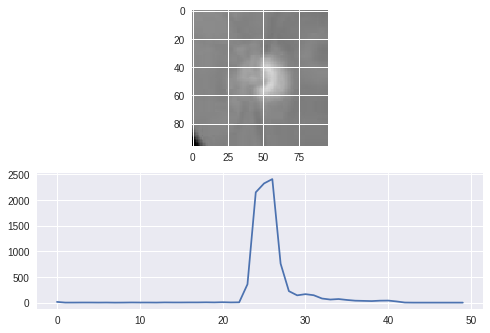

(50, 1)


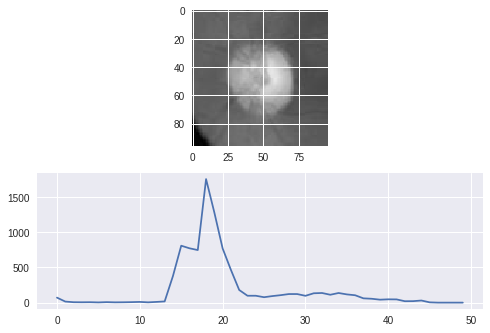

(50, 1)


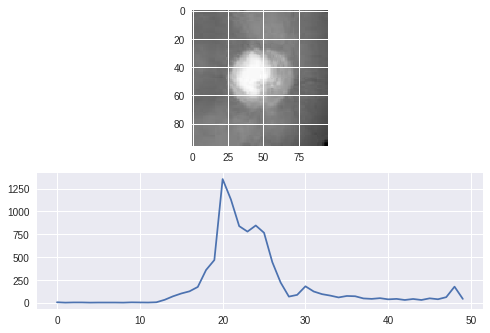

(50, 1)


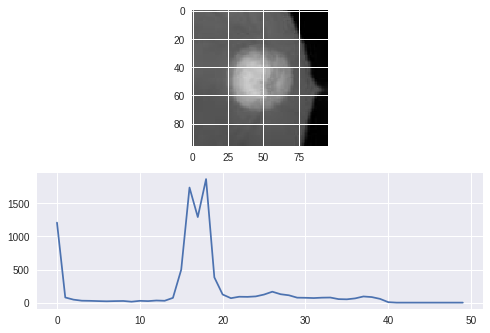

(50, 1)


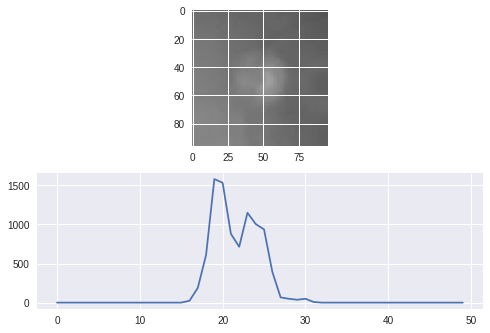

(50, 1)


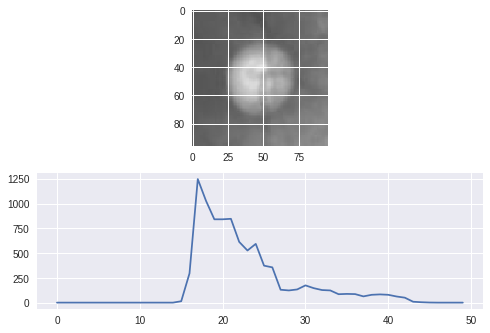

(50, 1)


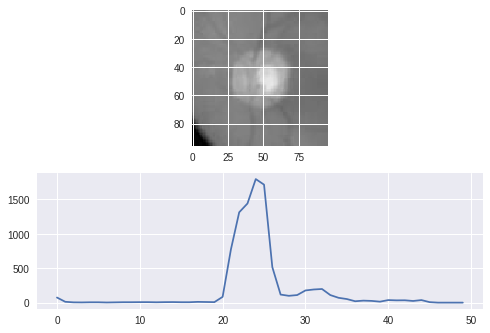

(50, 1)


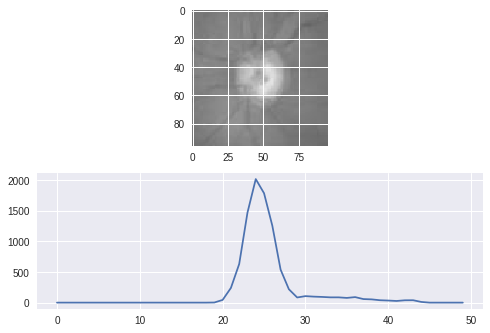

(50, 1)


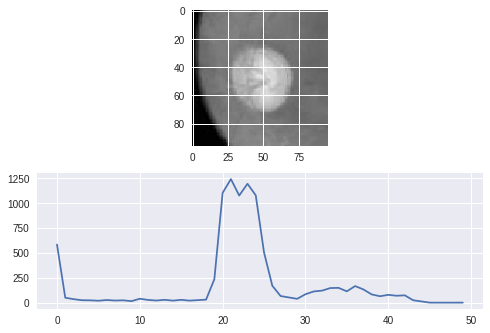

(50, 1)


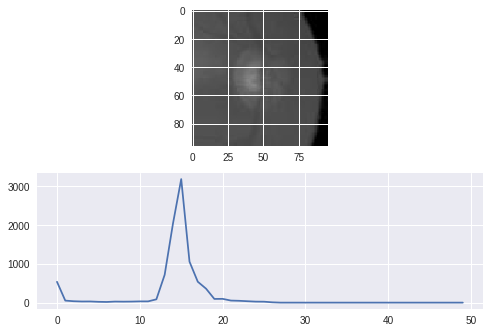

(50, 1)


(50, 1)


(50, 1)


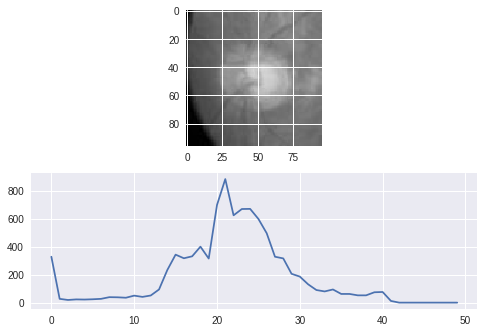

(50, 1)


(50, 1)


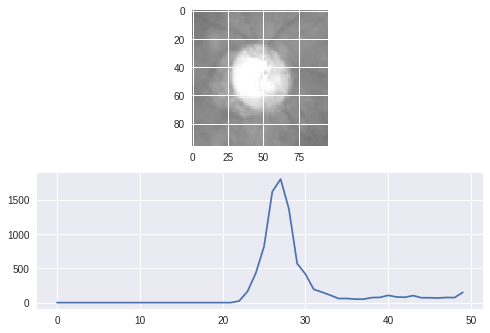

In [25]:
# find frequency of pixels in range 0-255
histograms = {}
i = 1
for n in os.listdir("FundusImagesv4/glaucoma"):
  n = cv2.imread("FundusImagesv4/glaucoma/"+n)
  f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  axarr[0].imshow(n)
  print(histr.shape)
  # show the plotting graph of an image
  axarr[1].plot(histr)
  plt.show()


(50, 1)


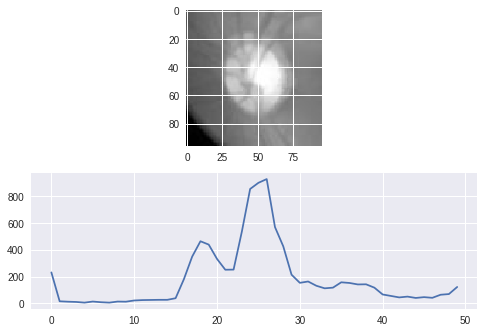

(50, 1)


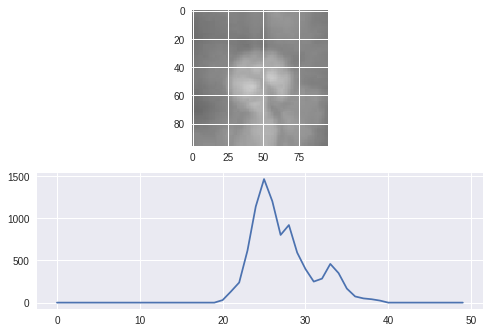

(50, 1)


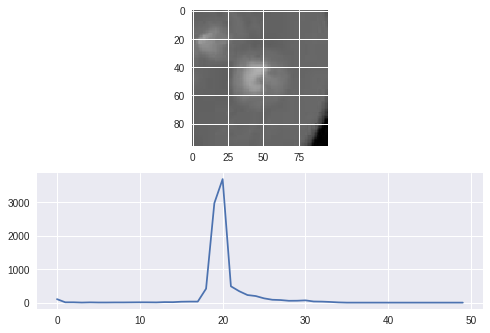

(50, 1)


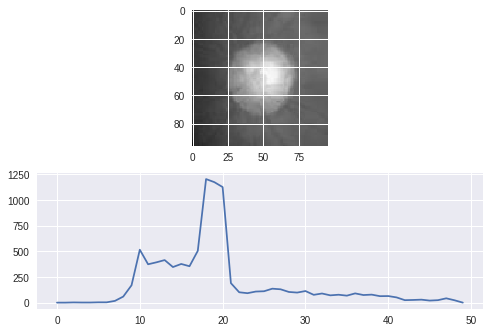

(50, 1)


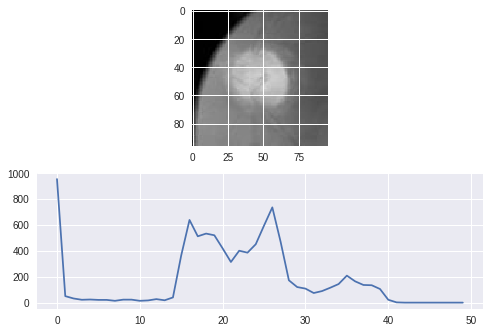

(50, 1)


(50, 1)


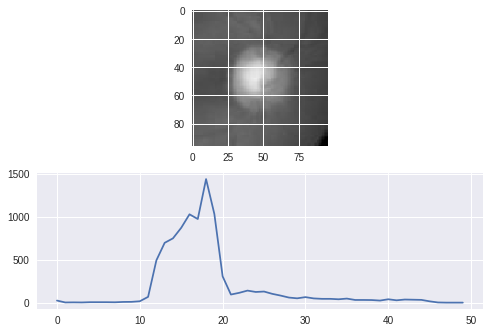

(50, 1)


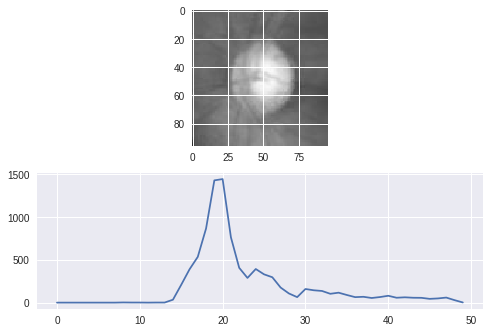

(50, 1)


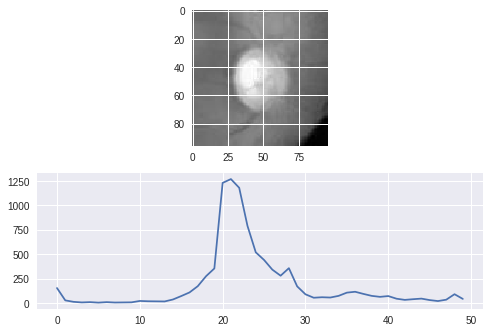

(50, 1)


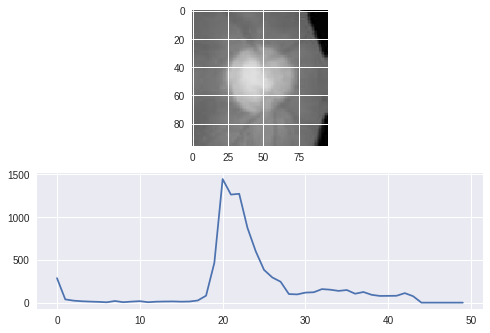

(50, 1)


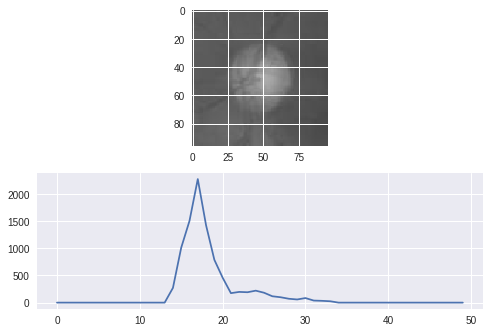

(50, 1)


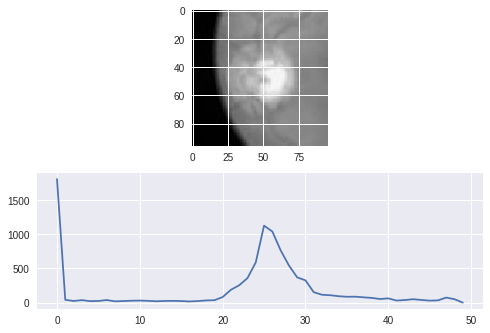

(50, 1)


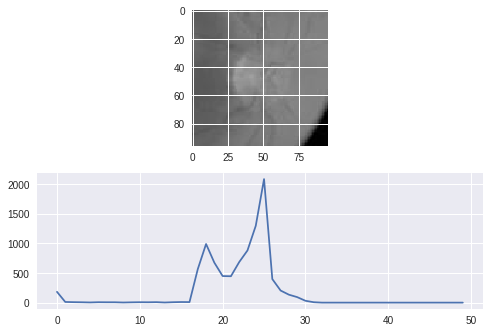

(50, 1)


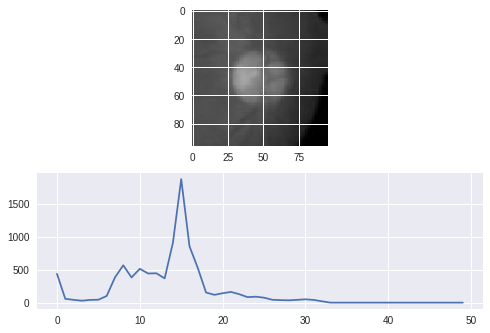

(50, 1)


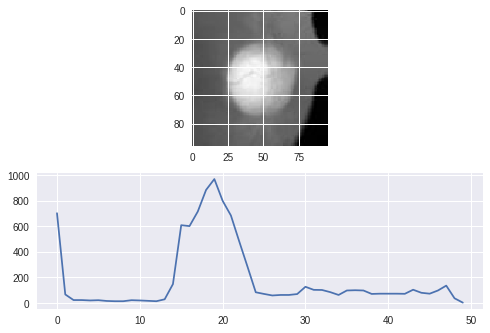

(50, 1)


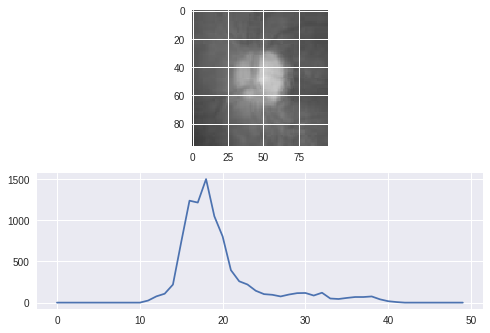

(50, 1)


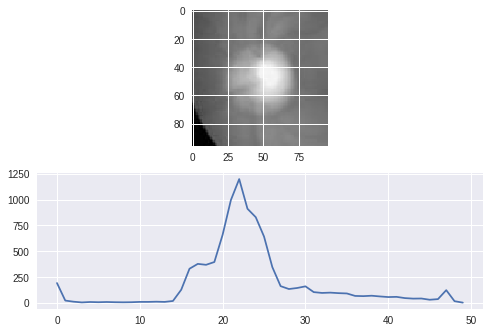

(50, 1)


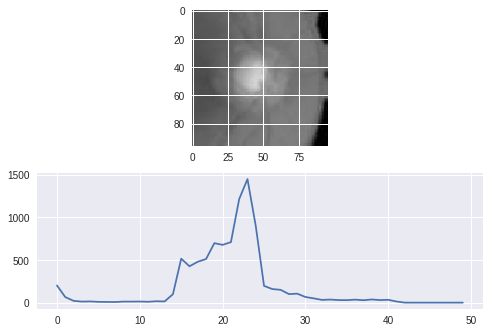

(50, 1)


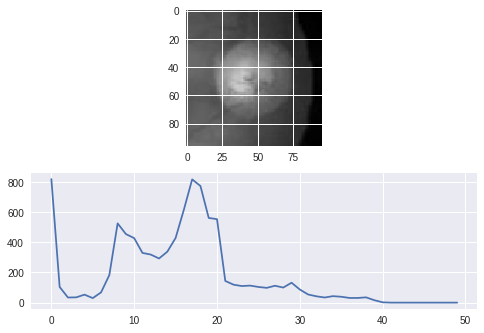

(50, 1)


(50, 1)


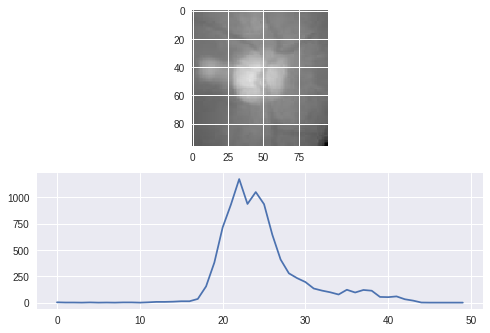

(50, 1)


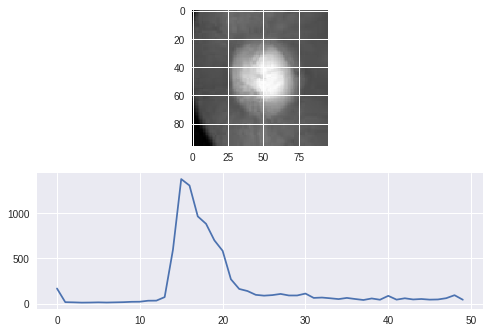

(50, 1)


(50, 1)


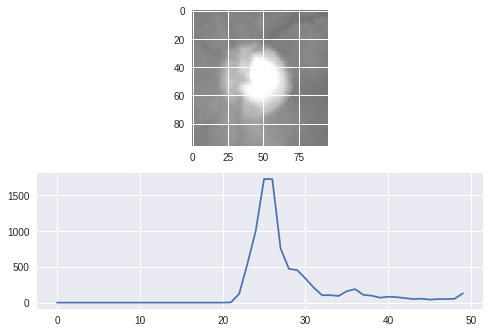

(50, 1)


(50, 1)


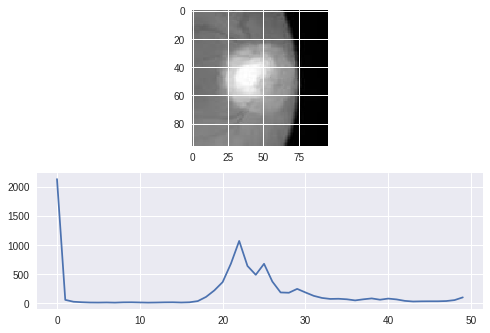

(50, 1)


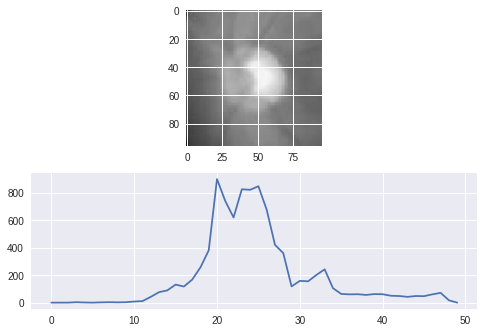

(50, 1)


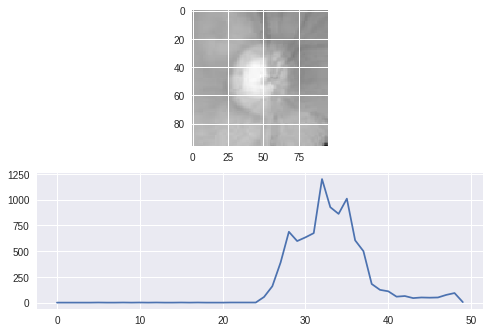

(50, 1)


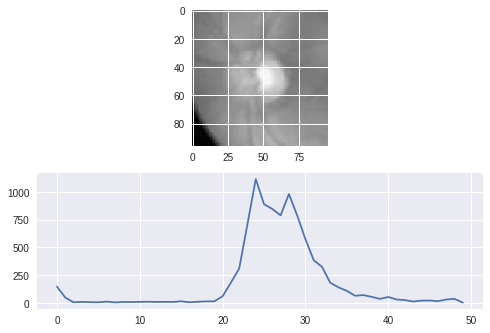

(50, 1)


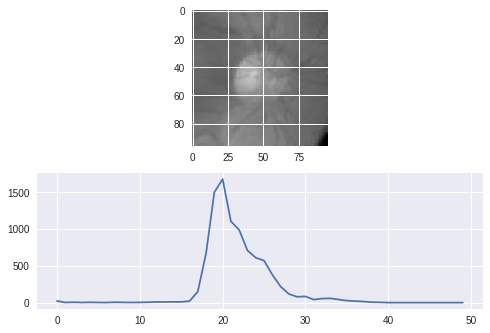

(50, 1)


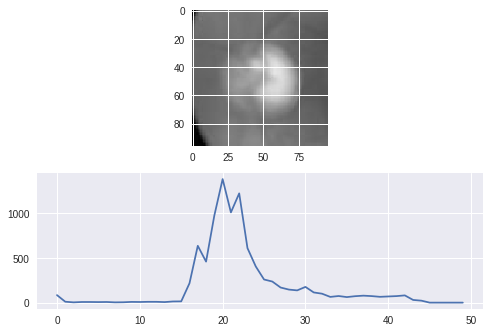

(50, 1)


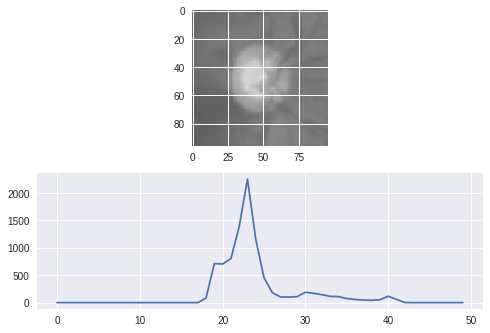

(50, 1)


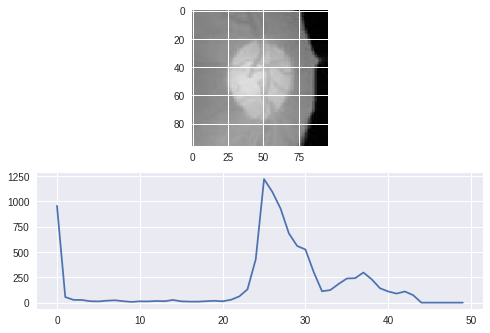

(50, 1)


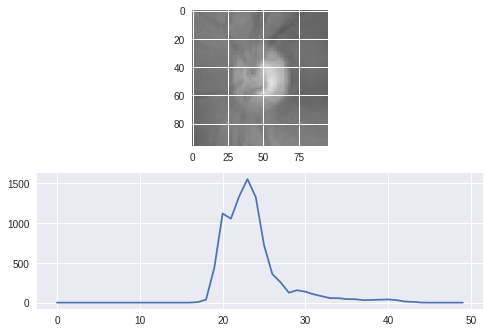

(50, 1)


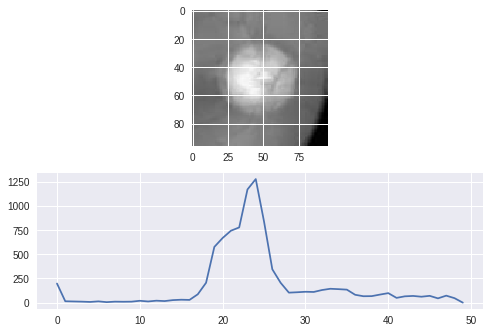

(50, 1)


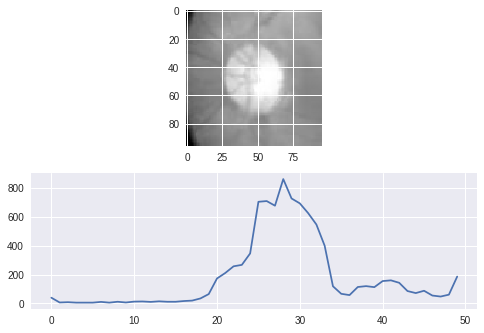

(50, 1)


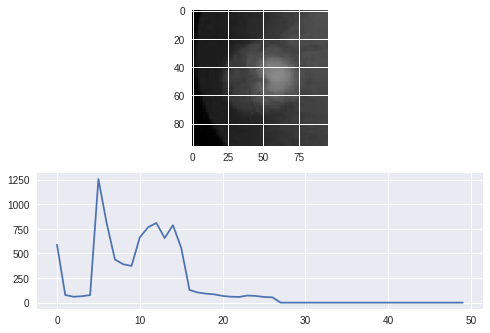

(50, 1)


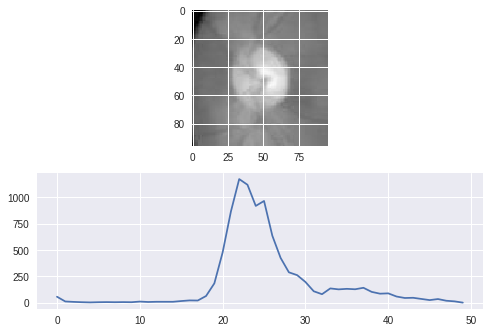

(50, 1)


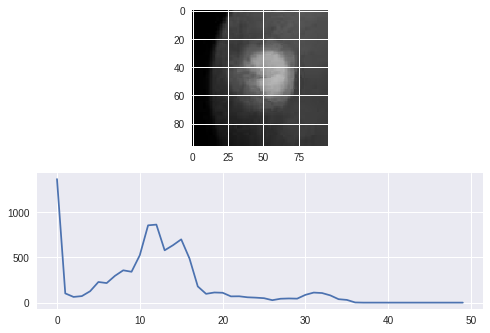

(50, 1)


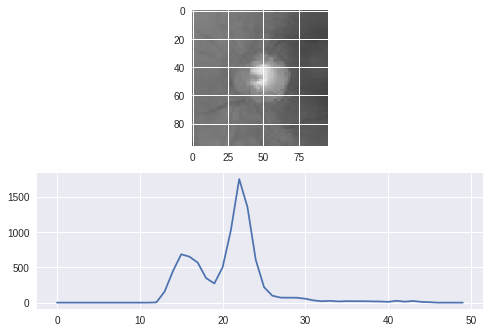

(50, 1)


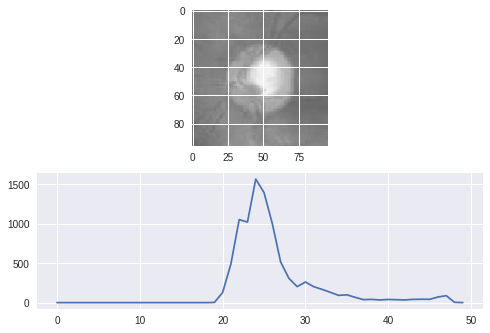

(50, 1)


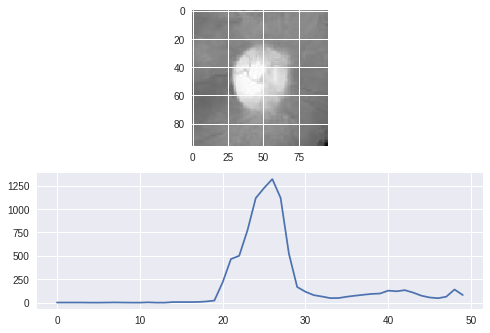

(50, 1)


(50, 1)


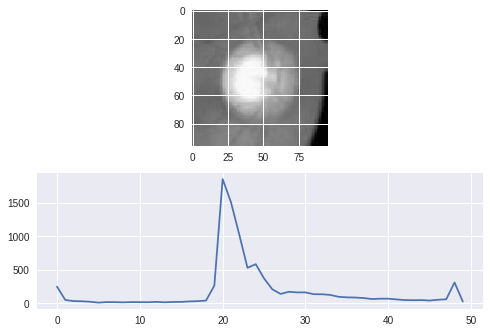

(50, 1)


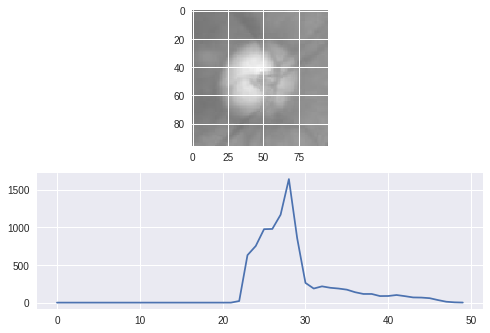

(50, 1)


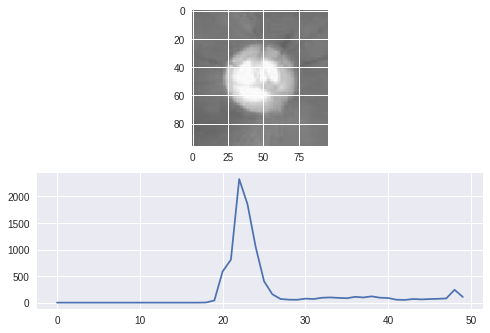

(50, 1)


(50, 1)


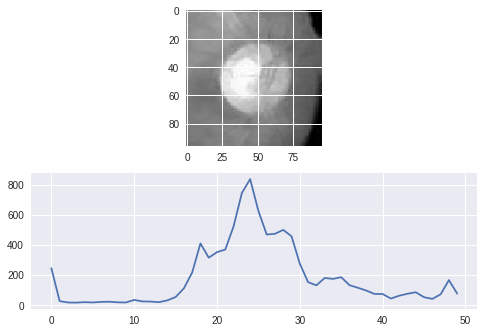

(50, 1)


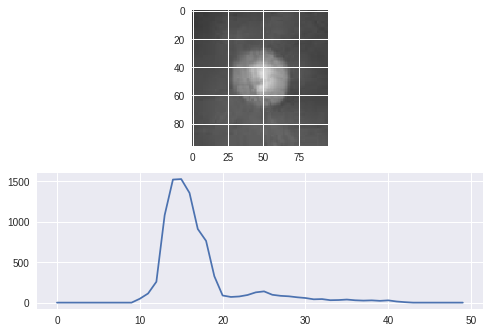

(50, 1)


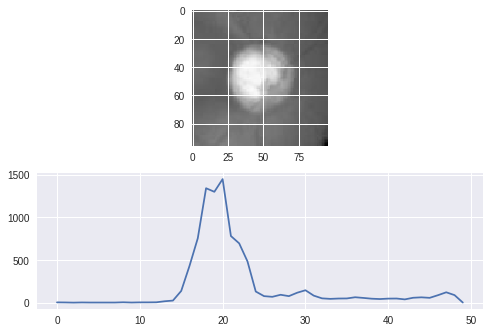

(50, 1)


(50, 1)


(50, 1)


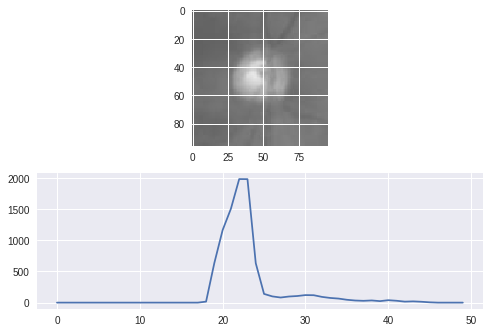

(50, 1)


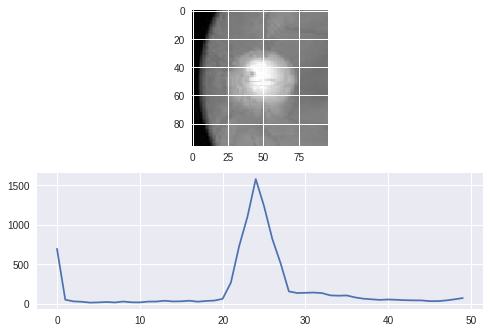

(50, 1)


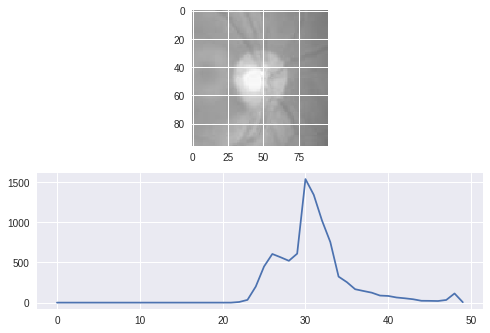

(50, 1)


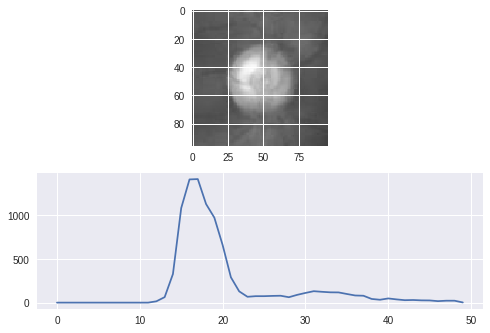

(50, 1)


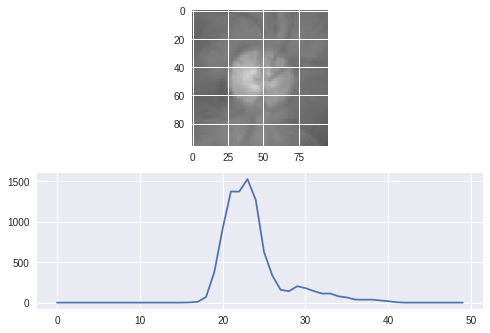

(50, 1)


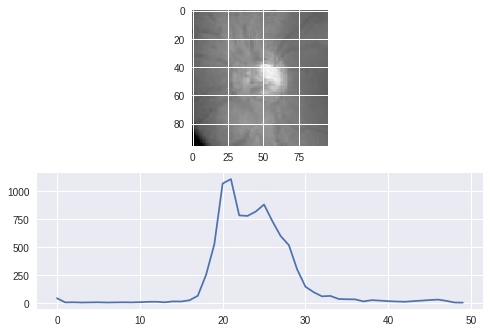

(50, 1)


(50, 1)


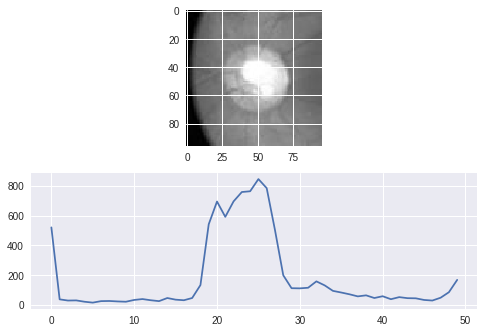

(50, 1)


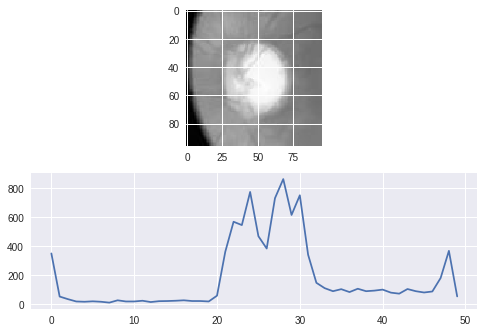

(50, 1)


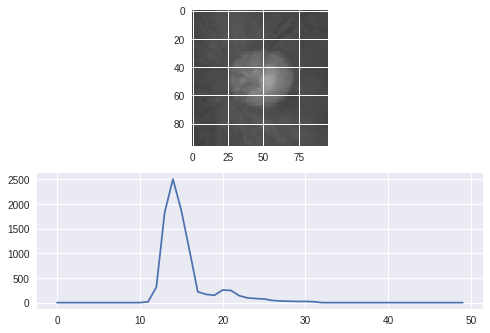

(50, 1)


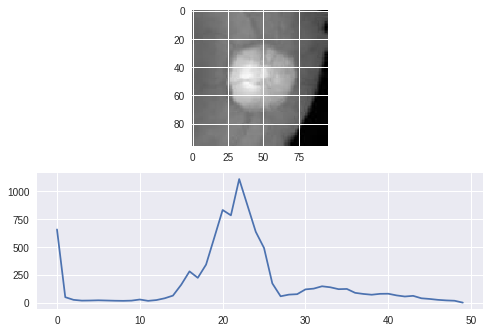

(50, 1)


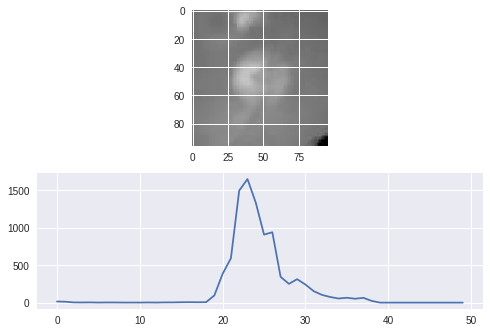

(50, 1)


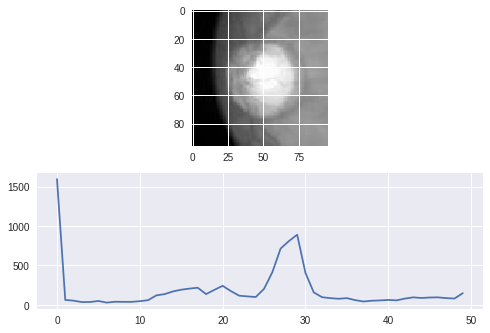

(50, 1)


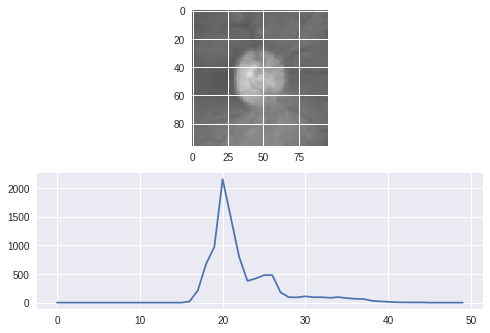

(50, 1)


(50, 1)


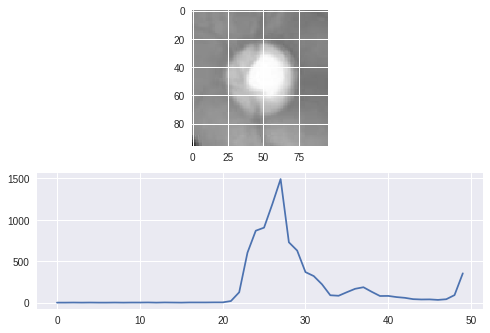

(50, 1)


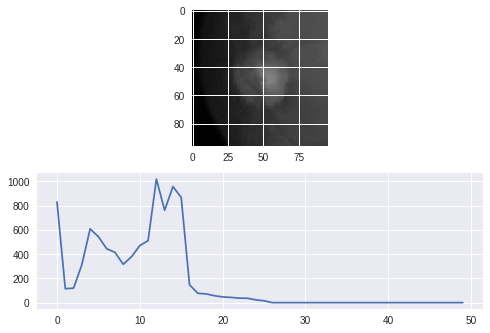

(50, 1)


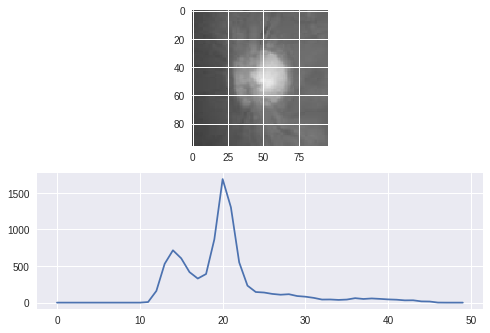

(50, 1)


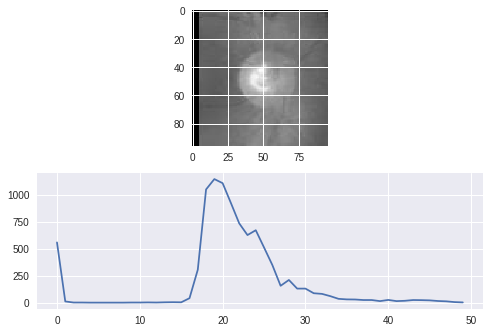

(50, 1)


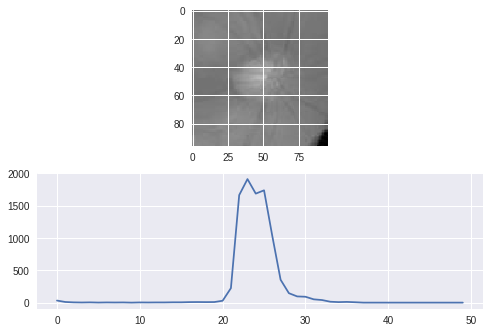

(50, 1)


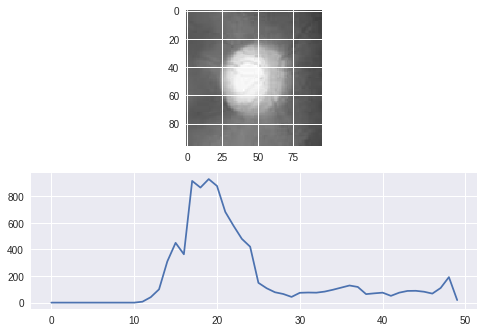

(50, 1)


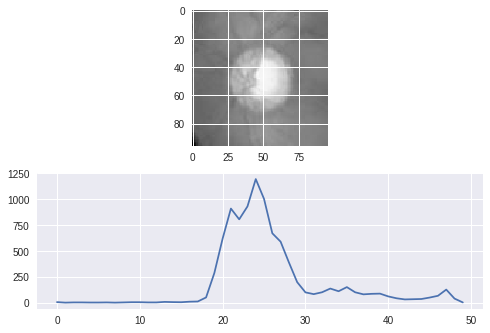

(50, 1)


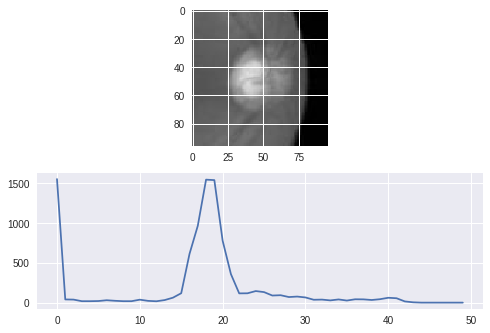

(50, 1)


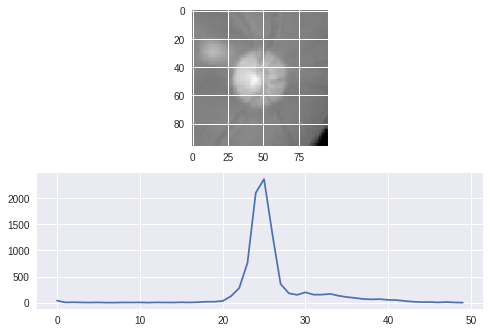

(50, 1)


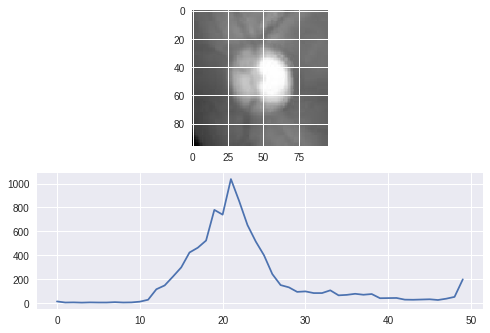

(50, 1)


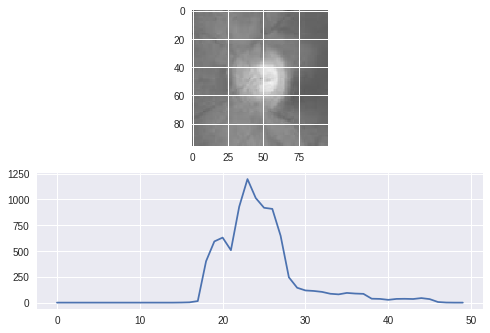

(50, 1)


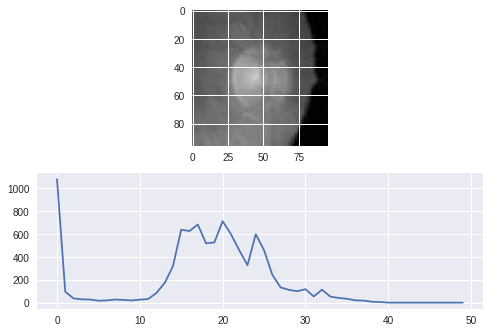

(50, 1)


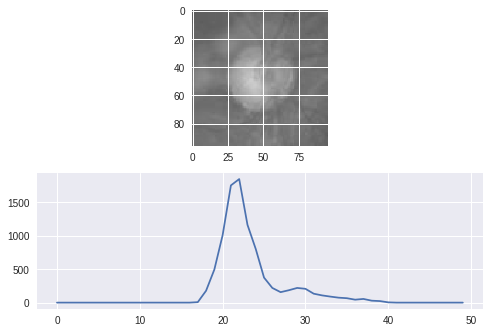

(50, 1)


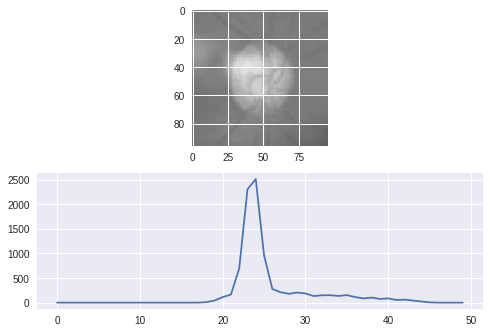

(50, 1)


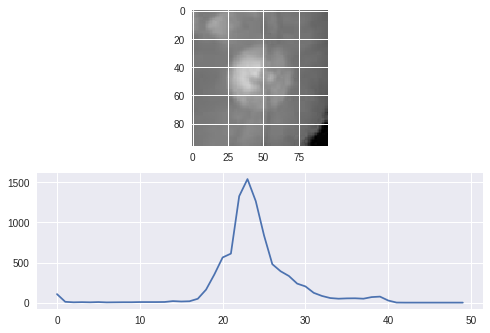

(50, 1)


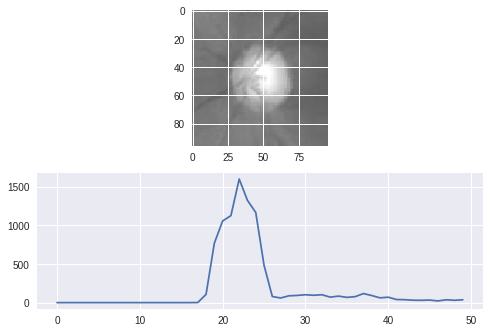

(50, 1)


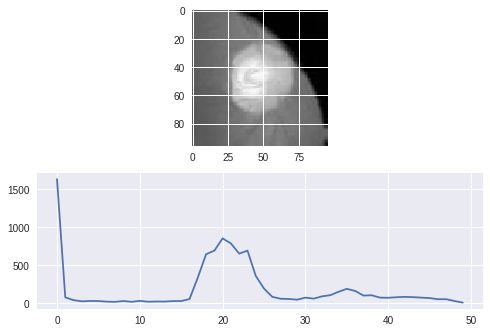

(50, 1)


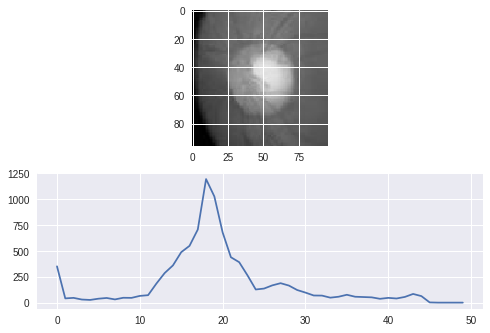

(50, 1)


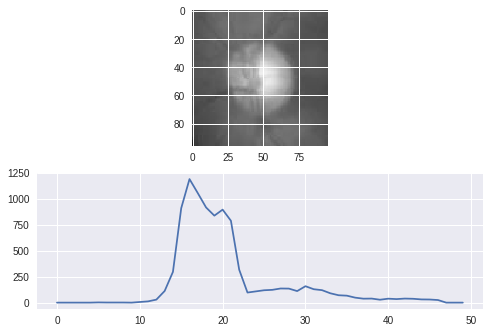

(50, 1)


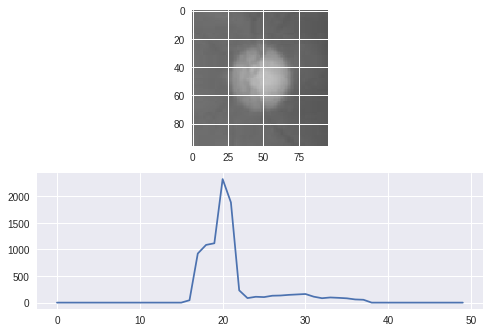

(50, 1)


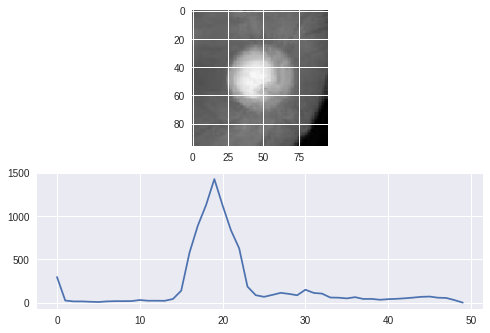

(50, 1)


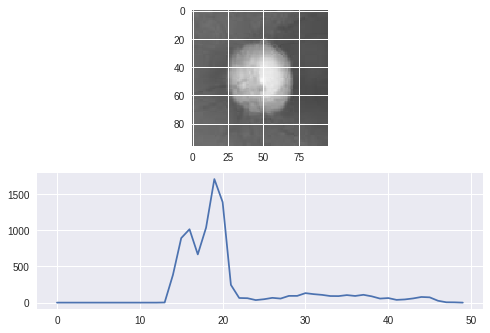

(50, 1)


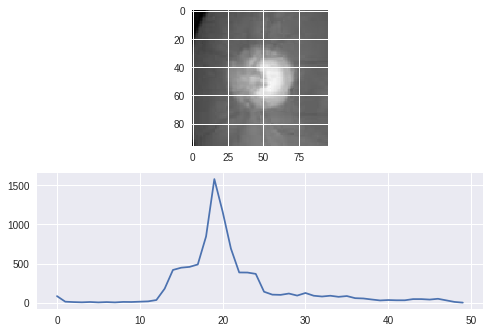

(50, 1)


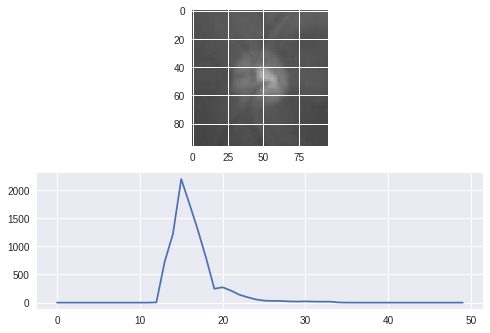

(50, 1)


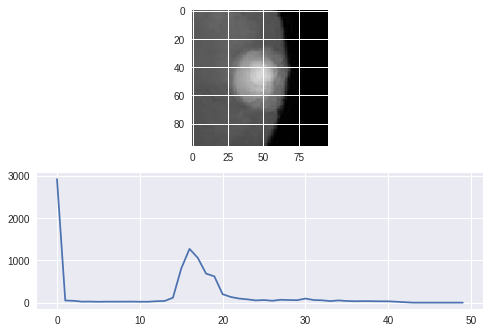

(50, 1)


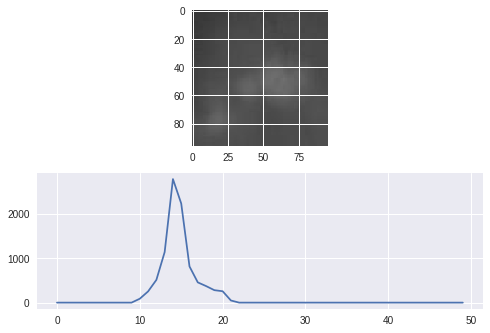

(50, 1)


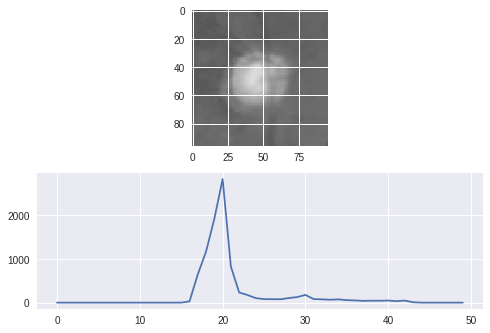

(50, 1)


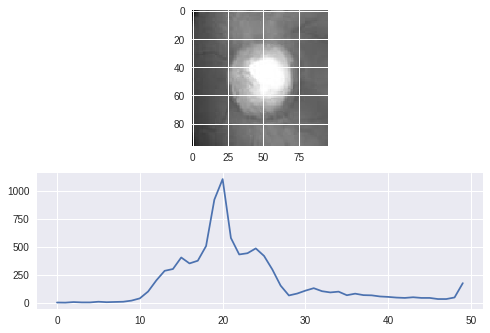

(50, 1)


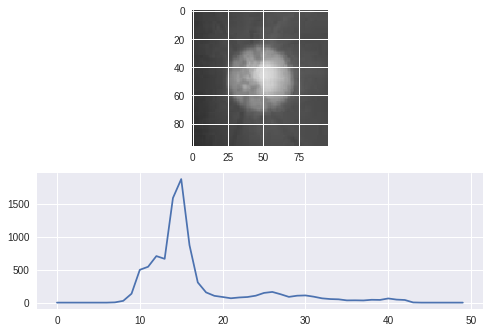

(50, 1)


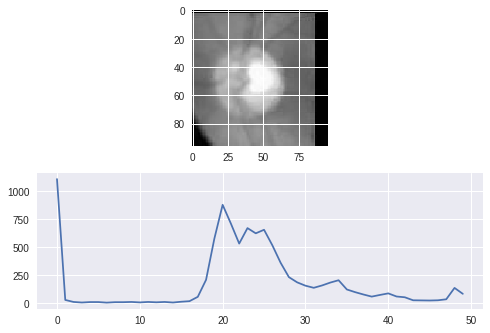

(50, 1)


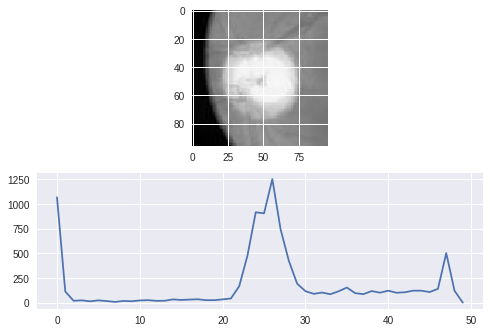

In [26]:
# find frequency of pixels in range 0-255
histograms = {}
i = 1
for n in os.listdir("FundusImagesv4/normal"):
  n = cv2.imread("FundusImagesv4/normal/"+n)
  f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  axarr[0].imshow(n)
  print(histr.shape)
  # show the plotting graph of an image
  axarr[1].plot(histr)
  plt.show()


In [27]:
# find frequency of pixels in range 0-255
histograms_glaucoma = {}
i = 1
for n in os.listdir("FundusImagesv4/glaucoma"):
  n = cv2.imread("FundusImagesv4/glaucoma/"+n)
  #f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  #axarr[0].imshow(n)
  histograms_glaucoma[i] = histr
  #show the plotting graph of an image
  #axarr[1].plot(histr[0])
  #plt.show()
  i+=1
histograms_normal = {}
i = 1
for n in os.listdir("FundusImagesv4/normal"):
  n = cv2.imread("FundusImagesv4/normal/"+n)
  #f,axarr = plt.subplots(2)
  histr = cv2.calcHist([n],[0],None,[50],[0,255])
  #axarr[0].imshow(n)
  histograms_normal[i] = histr
  # show the plotting graph of an image
  #axarr[1].plot(histr)
  #plt.show()
  i+=1
print(len(list(histograms_glaucoma.keys())))

70


In [28]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_g = [list(x.ravel()) for x in histograms_glaucoma.values()]
y_g = len(X_g)*[1]
X_n = [list(x.ravel()) for x in histograms_normal.values()]
y_n = len(X_n)*[0]
X = X_g + X_n
y = y_g + y_n
X = pd.DataFrame(X, columns = ["ps"+str(i) for i in range(50)])
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=2431)
clf = svm.SVC()
clf.fit(X_train, y_train)  



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions

In [29]:
print(clf.score(X_test,y_test))


0.6666666666666666


In [0]:
def build_filters():
  filters = []
  ksize = 31
  for theta in np.arange(0, np.pi, np.pi / 16):
    kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, .5, 0, ktype=cv2.CV_32F)
    kern /= 1.5*kern.sum()
    filters.append(kern)
  return filters
 
def process(img, filters):
  accum = np.zeros_like(img)
  for kern in filters:
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
    np.maximum(accum, fimg, accum)
  return accum


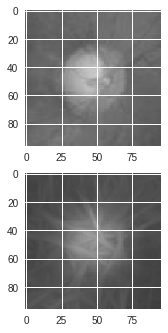

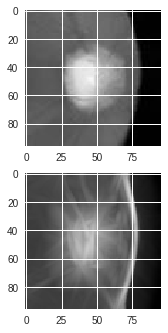

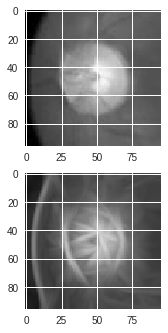

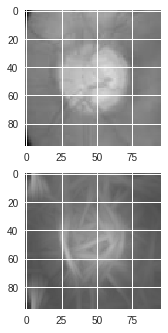

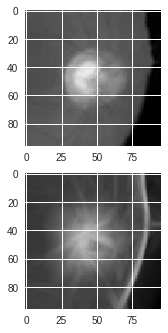

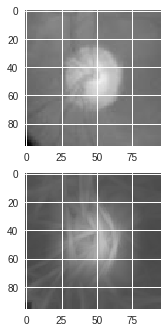

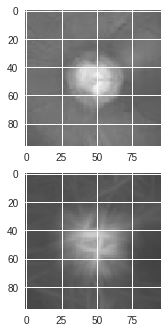

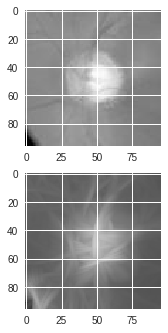

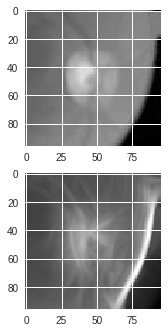

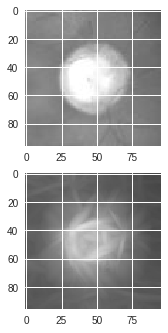

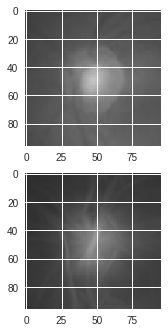

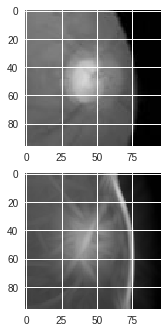

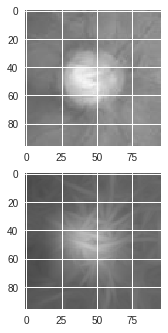

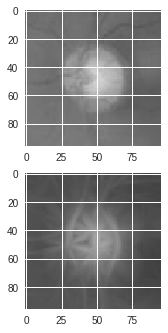

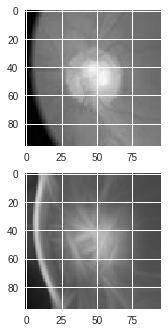

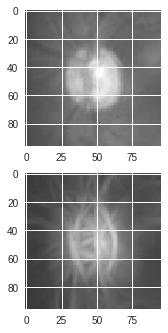

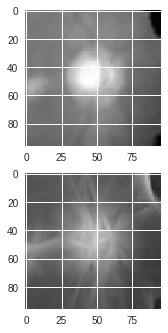

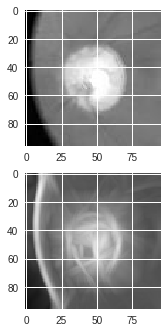

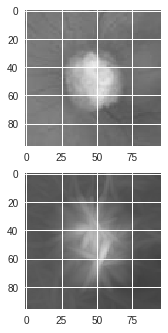

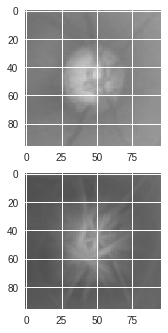

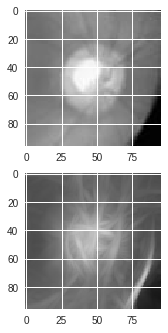

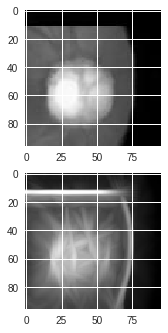

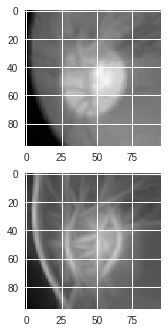

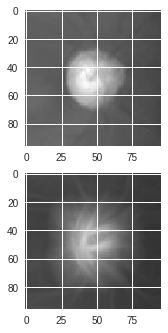

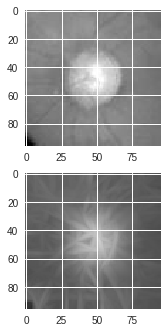

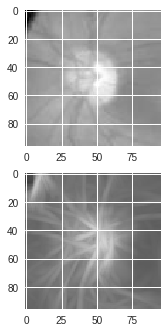

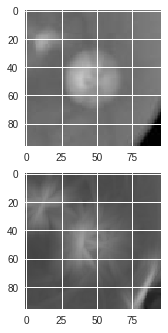

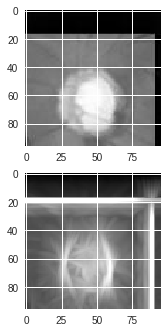

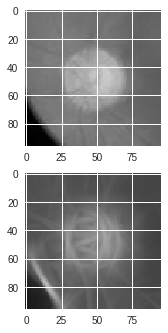

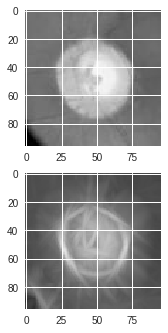

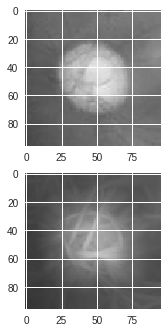

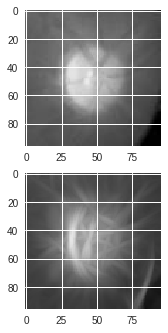

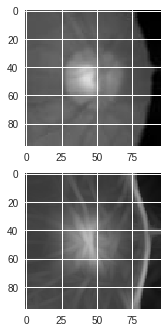

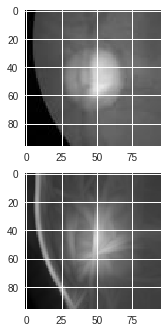

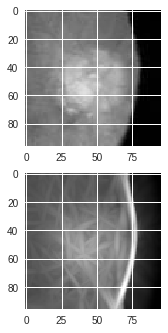

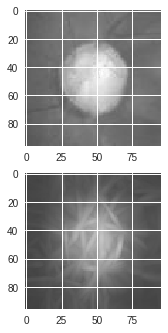

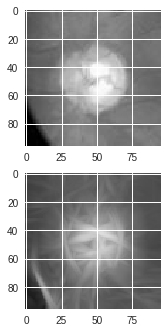

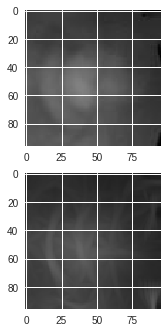

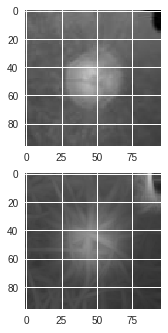

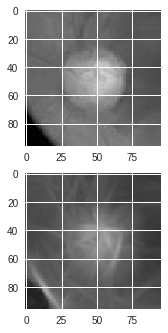

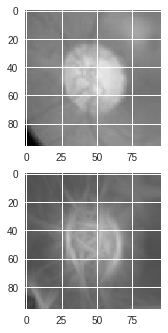

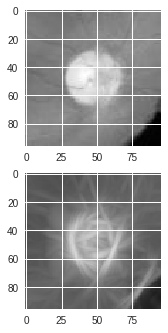

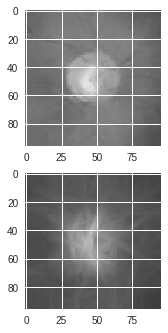

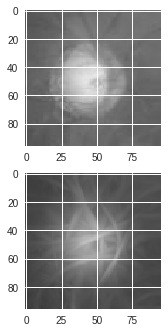

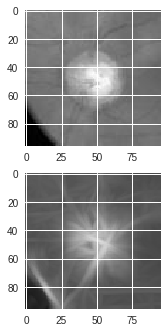

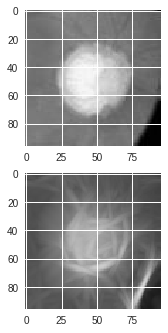

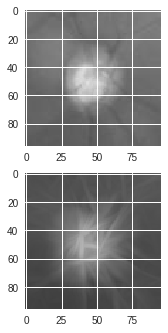

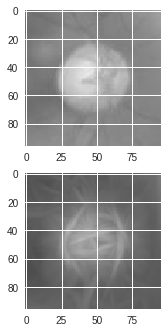

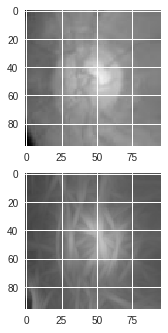

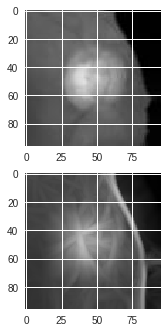

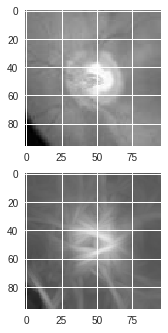

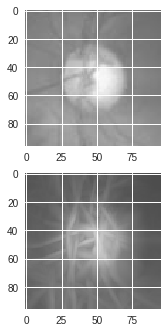

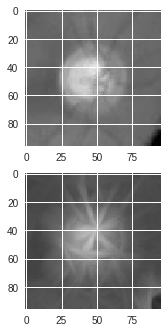

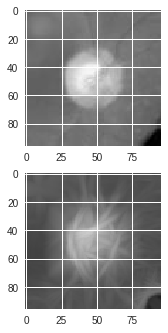

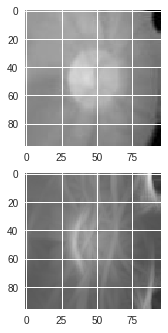

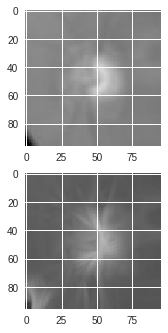

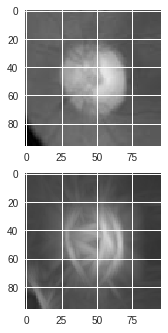

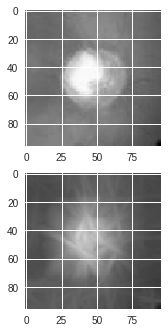

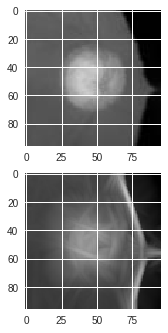

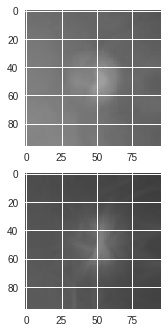

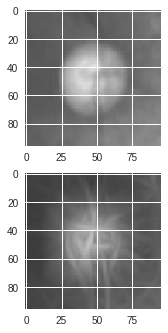

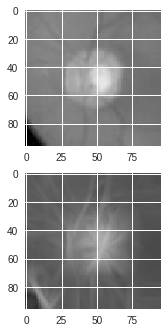

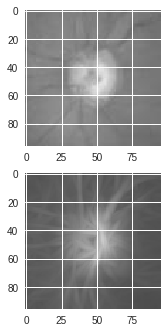

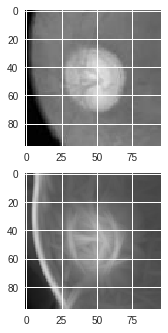

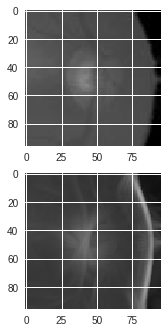

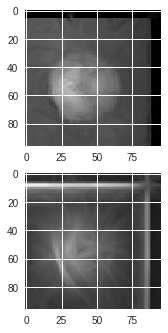

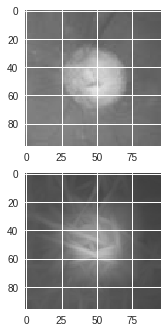

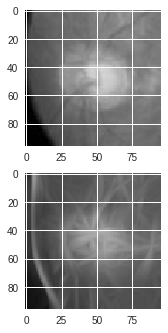

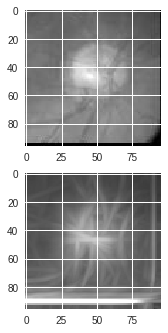

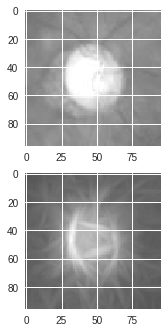

In [46]:
for next_glaucoma in os.listdir("FundusImagesv4/glaucoma"):
  t = cv2.imread("FundusImagesv4/glaucoma/"+next_glaucoma)
  f, axarr = plt.subplots(2)
  axarr[0].imshow(t)
  filters = build_filters()
  res1 = process(t, filters)
  axarr[1].imshow(res1)
  plt.show()

In [58]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(X_train)
train_img = pca.transform(X_train)
print(X_train.shape,train_img.shape)

(159, 50) (159, 11)


**Notes and to do:**

1. Using precedent from this paper - file:///C:/Users/Avyuk%20Dixit/Downloads/Classifying_Glaucoma_with_Image-Based_Features_fro.pdf - make sure to cite it

2. Three features - 1) pixel intensity values 2) histogram analysis of values, and 3) texture from gabor filter values

3. Do PCA on all features to reduce dimensionality - train and test SVM on each feature individually, and then merge all features and test SVM on it

4. Get all fundus images together on computer so we have a final train and test set, probably > 10000 images in total (what minimum split does there have to be between glaucoma vs non-glaucoma???)